

# **La Décalcomanie, 1966 by Rene Magritte**



![Transfer](https://raw.githubusercontent.com/asyaf/magritte/master/images/transfer.jpg)

# Setup

In [0]:
import cv2
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

In [3]:
!git clone https://github.com/asyaf/magritte.git
os.chdir("/content/magritte/code")

ROOT_DIR = os.path.abspath("..")

from utils import load_image, alpha_blend, display_image, \
    display_images, resize_image, mask_to_gray, trim_image, \
    paste_image_with_offset

fatal: destination path 'magritte' already exists and is not an empty directory.


In [0]:
IMG_PATH = os.path.join(ROOT_DIR, "images")
CAT_IMG = "cat_back.jpg"
CAT_IMG_PATH = os.path.join(IMG_PATH, CAT_IMG)
CURTAIN_IMG = "curtain.jpg"
CURTAIN_IMG_PATH = os.path.join(IMG_PATH, CURTAIN_IMG)
SEA_IMG = "sea.png"
SEA_IMG_PATH = os.path.join(IMG_PATH, SEA_IMG)

# Load Mask R-CNN

Use of pre-trained Mask R-CNN model to detect and segment objects.

(code taken from demo)

In [5]:
!git clone 'https://github.com/matterport/Mask_RCNN.git'

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [6]:
# Root directory of the project
MRCNN_ROOT_DIR = os.path.abspath("Mask_RCNN")

# Import Mask RCNN
sys.path.append(MRCNN_ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(MRCNN_ROOT_DIR, "samples/coco/"))  # To find local version
import coco

# Directory to save logs and trained model
MODEL_DIR = os.path.join(MRCNN_ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MRCNN_ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(MRCNN_ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


## Configurations

We'll be using a model trained on the MS-COCO dataset. 

In [7]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [8]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








## Class Names

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (1061, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


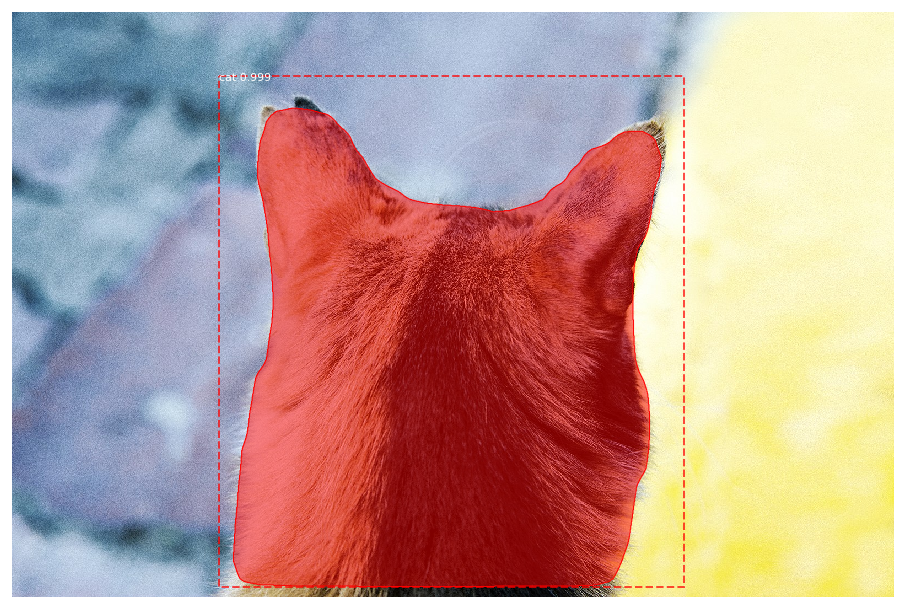

In [13]:
cat_img = load_image(CAT_IMG_PATH)

# Run detection
results = model.detect([cat_img], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(cat_img, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# Extract cat figure

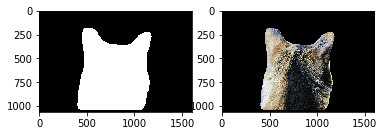

In [14]:
cat_mask = mask_to_gray(r['masks'][:,:,0])
extracted_cat_img = cv2.copyTo(cat_img, cat_mask)
img_list = [cat_mask, extracted_cat_img]
display_images(img_list)

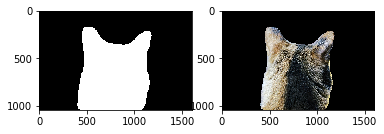

In [15]:
h, w, _ = extracted_cat_img.shape

min_x = 0
max_x = w
min_y = 0
max_y = h - 20

trimmed_cat_mask = trim_image(cat_mask, min_x, max_x, min_y, max_y)
trimmed_extracted_cat_img = trim_image(extracted_cat_img, min_x, max_x, min_y, max_y)
display_images([trimmed_cat_mask, trimmed_extracted_cat_img])

# Handle curtain

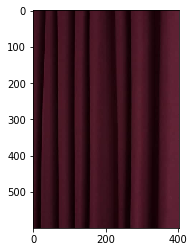

In [16]:
curtain_img = load_image(CURTAIN_IMG_PATH)
display_image(curtain_img)

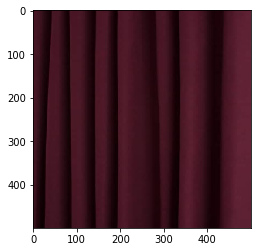

In [17]:
new_curtain_w, new_curtain_h = 500, 500
resized_curtain_img = resize_image(curtain_img, new_curtain_w, new_curtain_h)
display_image(resized_curtain_img)

# Handle sea

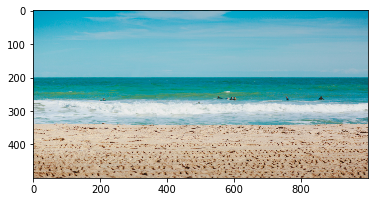

In [18]:
sea_img = load_image(SEA_IMG_PATH)
new_sea_w, new_sea_h = new_curtain_w * 2, new_curtain_h
resized_sea_img = resize_image(sea_img, new_sea_w, new_sea_h)
display_image(resized_sea_img)

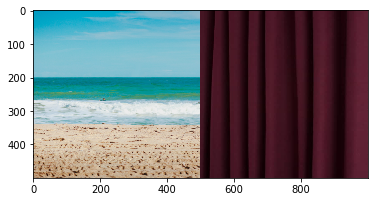

In [19]:
curtain_x_offset = new_curtain_w
sea_curtain_img = paste_image_with_offset(resized_sea_img, resized_curtain_img, 
                          curtain_x_offset, 0)
display_image(sea_curtain_img)

# Blend cat image

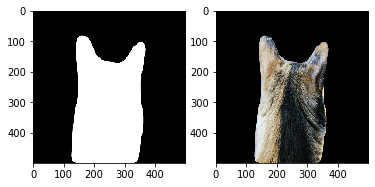

In [20]:
resized_cat_img = resize_image(trimmed_extracted_cat_img, new_curtain_w, new_curtain_h)
resized_cat_mask = resize_image(trimmed_cat_mask, new_curtain_w, new_curtain_h)
img_list = [resized_cat_mask, resized_cat_img]
display_images(img_list)

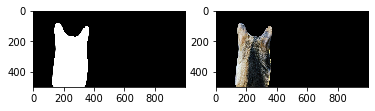

In [21]:
empty_img = np.zeros(sea_curtain_img.shape, dtype=np.uint8)
cat_x_offset = 0
cat_y_offset = 0
padded_cat_img = paste_image_with_offset(empty_img, resized_cat_img, 
                                         cat_x_offset, cat_y_offset)
rgb_cat_mask = cv2.cvtColor(resized_cat_mask, cv2.COLOR_GRAY2RGB)
padded_cat_mask = paste_image_with_offset(empty_img, rgb_cat_mask, 
                                         cat_x_offset, cat_y_offset)
img_list = [padded_cat_mask, padded_cat_img]
display_images(img_list)

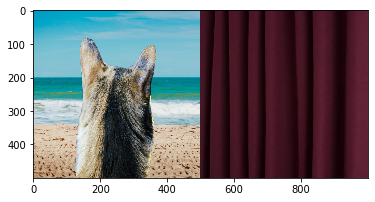

In [22]:
cat_sea_curtain_img = alpha_blend(padded_cat_img, sea_curtain_img, padded_cat_mask)
cat_sea_curtain_img = cat_sea_curtain_img.astype(np.uint8)
display_image(cat_sea_curtain_img)

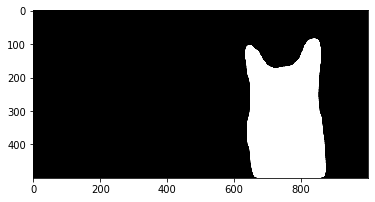

In [23]:
mirrored_padded_cat_mask = cv2.flip(padded_cat_mask, 1)
display_image(mirrored_padded_cat_mask)

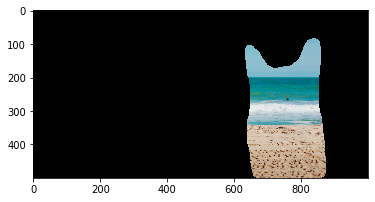

In [24]:
extracted_sea_img = cv2.copyTo(resized_sea_img, mirrored_padded_cat_mask)
display_image(extracted_sea_img)

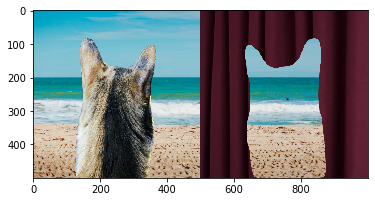

In [25]:
res_img = alpha_blend(extracted_sea_img, cat_sea_curtain_img, mirrored_padded_cat_mask)
res_img = res_img.astype(np.uint8)
display_image(res_img)